In [15]:
from ipynb.fs.full.exploration_cleaning import get_data

### Difference between weekday and weekend.

In [17]:
# Turn strings in to pandas date.
data['Date'] = pd.to_datetime(data['Date'], yearfirst = True)
# Get the day of the week for each date.
data['dayofweek'] = data['Date'].dt.dayofweek
data.head()

C:\Users\fred_\AppData\Local\Temp\ipykernel_15312\3191454190.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'], yearfirst = True)


,Station or stop,Date,Number of train rides,Minutes of delay,Name,Country,Coordinate Latitude,Coordinate Longitude,dayofweek
0,80197079,2016-03-16,39,49,KINDSBACH,DEUTSCHLAND,49.42045,7.613668,2
1,80197079,2016-11-10,38,74,KINDSBACH,DEUTSCHLAND,49.42045,7.613668,3
2,80197079,2016-08-29,27,33,KINDSBACH,DEUTSCHLAND,49.42045,7.613668,0
3,80197079,2016-02-25,53,85,KINDSBACH,DEUTSCHLAND,49.42045,7.613668,3
4,80197079,2016-05-28,39,38,KINDSBACH,DEUTSCHLAND,49.42045,7.613668,5


In [10]:
data_weekday = data.loc[data['dayofweek'].isin([0, 1, 2, 3, 4])]
data_weekend = data.loc[data['dayofweek'].isin([5, 6])]

<Axes: >

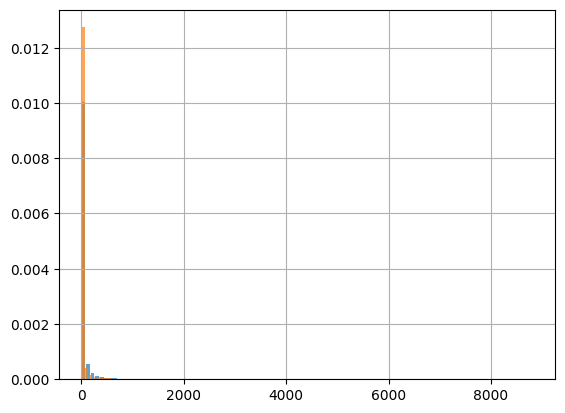

In [17]:
data_weekday["Minutes of delay"].hist(bins = 100, rwidth = 0.8, density = True, alpha = .7)
data_weekend["Minutes of delay"].hist(bins = 100, rwidth = 0.8, density = True, alpha = .7)

<Axes: >

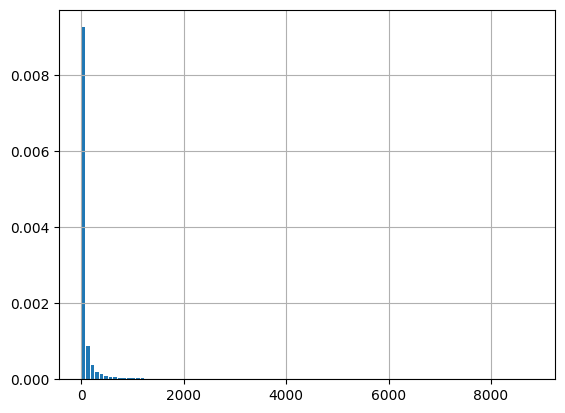

In [11]:
data_weekday[data_weekday["Minutes of delay"] != 0]["Minutes of delay"].hist(bins = 100, rwidth = 0.8, density = True)

<Axes: >

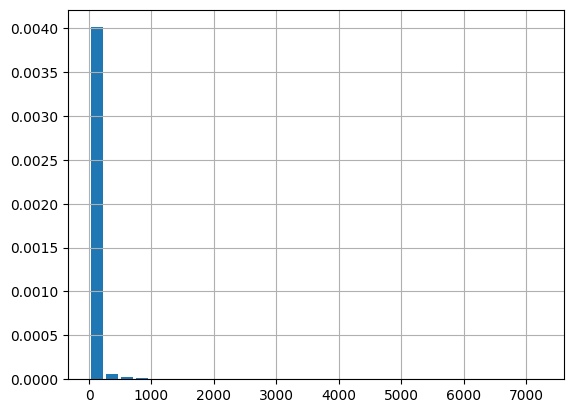

In [13]:
data_weekend["Minutes of delay"].hist(bins = 30, rwidth = 0.8, density = True)

In [26]:
data_weekday

,Station or stop,Date,Number of train rides,Minutes of delay,Name,Country,Coordinate Latitude,Coordinate Longitude,dayofweek
0,80197079,2016-03-16,39,49,KINDSBACH,DEUTSCHLAND,49.420450,7.613668,2
1,80197079,2016-11-10,38,74,KINDSBACH,DEUTSCHLAND,49.420450,7.613668,3
2,80197079,2016-08-29,27,33,KINDSBACH,DEUTSCHLAND,49.420450,7.613668,0
3,80197079,2016-02-25,53,85,KINDSBACH,DEUTSCHLAND,49.420450,7.613668,3
5,80197079,2016-08-09,32,35,KINDSBACH,DEUTSCHLAND,49.420450,7.613668,1
...,...,...,...,...,...,...,...,...,...
766023,80101972,2016-04-07,12,0,DORTMUND BUSCHSTRASSE,DEUTSCHLAND,51.538476,7.395210,3
766024,80264408,2016-08-18,10,14,SCHWAIGEN,DEUTSCHLAND,48.665453,12.598961,3
766025,80233973,2016-08-11,10,0,HOHENRODA,DEUTSCHLAND,51.499080,12.421535,3
766026,80060517,2016-09-15,14,2,DRESDEN-DOBRITZ,DEUTSCHLAND,51.013900,13.808676,3


#### Calculate mean for every station by weekday or weekend

In [27]:
data_weekday_mean = data_weekday.groupby('Station or stop')['Minutes of delay'].mean()
data_weekend_mean = data_weekend.groupby('Station or stop')['Minutes of delay'].mean()
data_by_weekday_weekend = pd.merge(data_weekday_mean, data_weekend_mean, how = "left", on = "Station or stop", suffixes = ("_weekday", "_weekend"))
data_by_weekday_weekend

,Minutes of delay_weekday,Minutes of delay_weekend
Station or stop,,
80010561,0.000000,0.000000
80010579,11.809735,6.157895
80010587,0.000000,0.000000
80010660,436.559735,192.806452
80010694,114.602881,26.587912
...,...,...
80944025,0.000000,0.000000
80944033,0.000000,0.000000
80944348,1.936170,0.500000


In [28]:
data_by_weekday_weekend.idxmax()

Minutes of delay_weekday    80031732
Minutes of delay_weekend    80031732
dtype: int64

In [29]:
diff_weekday_weekend = (data_by_weekday_weekend["Minutes of delay_weekday"] - data_by_weekday_weekend["Minutes of delay_weekend"])
diff_weekday_weekend2 = diff_weekday_weekend.drop(diff_weekday_weekend.idxmax())

<Axes: >

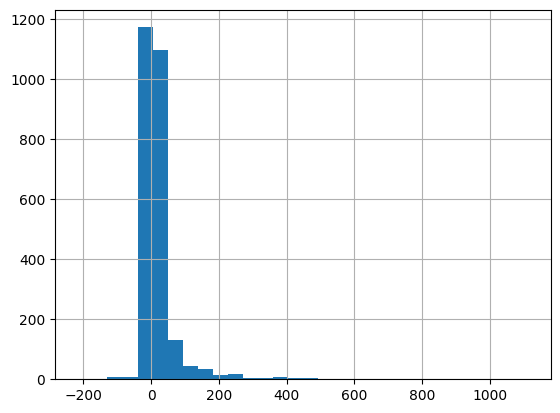

In [30]:
diff_weekday_weekend.hist(bins=30)

<Axes: >

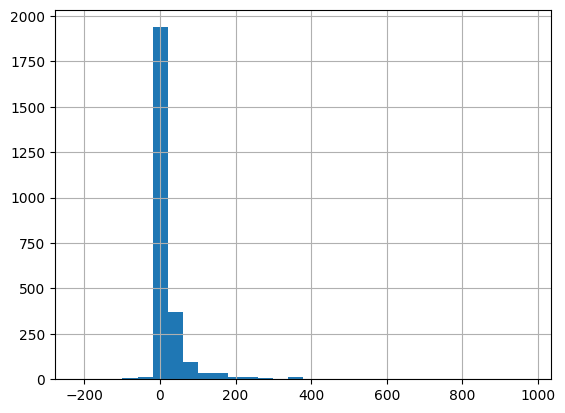

In [31]:
diff_weekday_weekend2.hist(bins=30)

In [21]:
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib import ticker
import matplotlib.pyplot as plt

TODO: Use mean over all stations of weekend / weekday

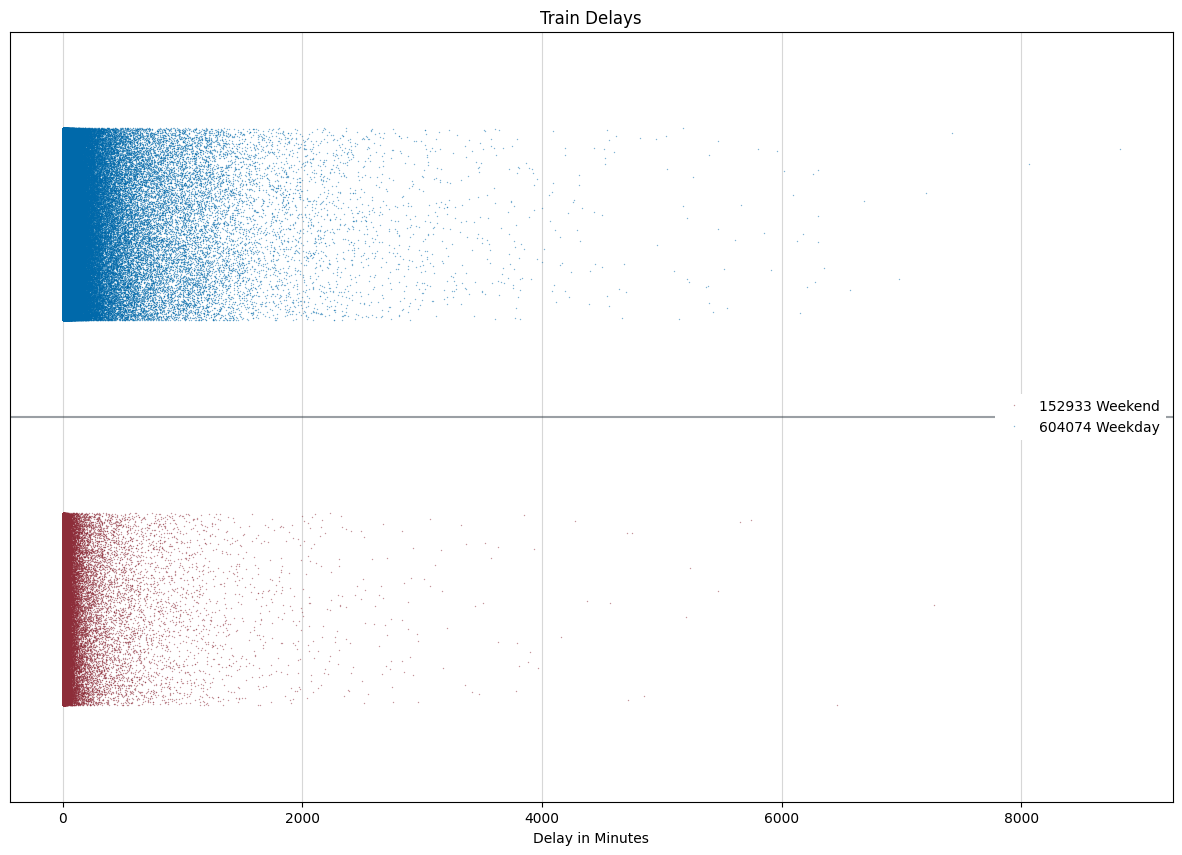

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Train Delays")
ax.set_xlabel("Delay in Minutes")

n_we = data_weekend.shape[0] # number of female runners
n_wd = data_weekday.shape[0] # number of male runners

np.random.seed(1)
u_we = np.random.rand(n_we)
u_wd = np.random.rand(n_wd)

ax.plot(
    data_weekend["Minutes of delay"], 0.5 * u_we, "o", label=f"{n_we} Weekend", color=rgb.tue_red, alpha=0.5, mec = "none", ms = 1
)
ax.plot(
    data_weekday["Minutes of delay"], 1 + 0.5 * u_wd, "o", label=f"{n_wd} Weekday", color=rgb.tue_blue, alpha=0.5, mec = "none", ms = 1
)


# set the x-axis formatter to the custom function
#ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_seconds))
ax.legend(loc = 'center right', framealpha = 1.0, facecolor = 'white', edgecolor = 'none')
ax.grid(axis = 'x', which = 'major', alpha = 0.5)
ax.yaxis.set_visible(False)
ax.axhline(0.75, color = rgb.tue_dark, alpha = 0.5)
ax.set_ylim(-0.25, 1.75)

plt.show()

In [24]:
n_we = data_weekend.shape[0] # number of weekends
n_wd = data_weekday.shape[0] # number of weekdays

N = n_we + n_we # total number of days
Y = np.concatenate([data_weekend['Minutes of delay'].values, data_weekday['Minutes of delay'].values]) # all delay times, shape = (1, N)
X = np.bool_(np.concatenate([np.ones(n_we),np.zeros(n_wd)])) # TRUE if girl, FALSE otherwise, shape = (1, N)

In [29]:
rng = np.random.default_rng(1) # random number generator
B = 4000 # number of permuations to produce

# repeat Y (one row) B times, shape now = (B, N), then shuffle the columns
X_permuted = rng.permuted(np.tile(X, (B,1)), axis=1) 

In [30]:
def T_mean(group):
    '''How much faster is the average girl?'''
    return np.mean(Y[~group]) - np.mean(Y[group])

# the statistics for the original data
mean_true = T_mean(X)

# the statistics for the permuted data
mean_dist = np.apply_along_axis(T_mean, 1, X_permuted)

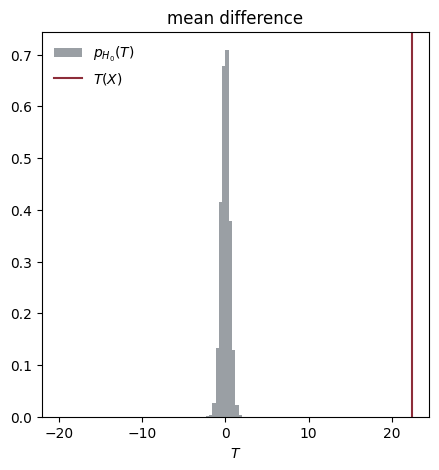

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-20, 20, 101)
ax.set_title('mean difference')
ax.hist(mean_dist, bins=bins, density=True, label='$p_{H_0}(T)$', alpha=0.5, color=rgb.tue_dark)
ax.axvline(mean_true, label='$T(X)$', alpha=1.0, color=rgb.tue_red)
ax.legend(loc='upper left', frameon=False)
#ax.yaxis.set_visible(False)
ax.set_xlabel('$T$')

plt.savefig('permutation_distributions.pdf')

In [120]:
bins = np.linspace(-40, 40, 101)
loc_data = np.argmax(bins >= mean_true)
histogram,_ = np.histogram(mean_dist, bins=bins, density=True)
empirical_cdf = np.cumsum(histogram) / np.sum(histogram)

p_value = empirical_cdf[loc_data]
print(p_value)

1.0


In [69]:
data_weekday["Minutes of delay"].mean()

53.94466240891017

In [70]:
data_weekend["Minutes of delay"].mean()

31.541367788508694

In [78]:
Y = np.concatenate([data_weekend["Minutes of delay"].values, data_weekday["Minutes of delay"].values]) # all race times, shape = (1, N)
rng = np.random.default_rng(1) # random number generator
B = 100000 # number of permuations to produce

In [ ]:
fig, axs = plt.subplots(1,4)

ax = axs[0]
bins = np.linspace(-15, 15, 31)
ax.set_title('mean difference')
ax.hist(mean_dist, bins=bins, density=True, label='$p_{H_0}(T)$', alpha=0.5, color=rgb.tue_dark)
ax.axvline(mean_true, label='$T(X)$', alpha=1.0, color=rgb.tue_red)
ax.legend(loc='upper right', frameon=False)
ax.yaxis.set_visible(False)
ax.set_xlabel('$T$')